In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns


In [3]:
df = pd.read_csv("HDFS_2k.log", header=None, names=['raw_log'])
df.head()

,raw_log
0,081109 203615 148 INFO dfs.DataNode$PacketResp...
1,081109 203807 222 INFO dfs.DataNode$PacketResp...
2,081109 204005 35 INFO dfs.FSNamesystem: BLOCK*...
3,081109 204015 308 INFO dfs.DataNode$PacketResp...
4,081109 204106 329 INFO dfs.DataNode$PacketResp...


In [4]:
def clean_log(text):
    text = re.sub(r'\d+', '', text)           # remove numbers
    text = re.sub(r'[^a-zA-Z ]', '', text)    # remove special chars
    return text.lower().strip()

df['clean_log'] = df['raw_log'].apply(clean_log)

In [5]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['clean_log'])

In [6]:
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_score'] = model.fit_predict(X.toarray())


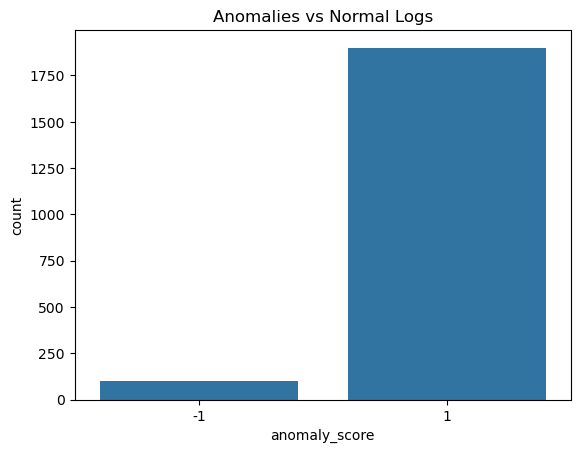

Detected Anomalies:


,raw_log,clean_log,anomaly_score
28,081109 205931 13 INFO dfs.DataBlockScanner: Ve...,info dfsdatablockscanner verification succeede...,-1
69,081109 213436 13 INFO dfs.DataBlockScanner: Ve...,info dfsdatablockscanner verification succeede...,-1
77,081109 214043 2561 WARN dfs.DataNode$DataXceiv...,warn dfsdatanodedataxceiver got exception whil...,-1
78,081109 214402 2677 WARN dfs.DataNode$DataXceiv...,warn dfsdatanodedataxceiver got exception whil...,-1
80,081109 214529 2747 WARN dfs.DataNode$DataXceiv...,warn dfsdatanodedataxceiver got exception whil...,-1
81,081109 214910 2848 WARN dfs.DataNode$DataXceiv...,warn dfsdatanodedataxceiver got exception whil...,-1
83,081109 215136 2868 WARN dfs.DataNode$DataXceiv...,warn dfsdatanodedataxceiver got exception whil...,-1
84,081109 215259 2934 WARN dfs.DataNode$DataXceiv...,warn dfsdatanodedataxceiver got exception whil...,-1
85,081109 215702 3022 WARN dfs.DataNode$DataXceiv...,warn dfsdatanodedataxceiver got exception whil...,-1
87,081109 220032 3137 WARN dfs.DataNode$DataXceiv...,warn dfsdatanodedataxceiver got exception whil...,-1


In [7]:
sns.countplot(x=df['anomaly_score'])
plt.title("Anomalies vs Normal Logs")
plt.show()

anomalies = df[df['anomaly_score'] == -1]
print("Detected Anomalies:")
display(anomalies.head(10))


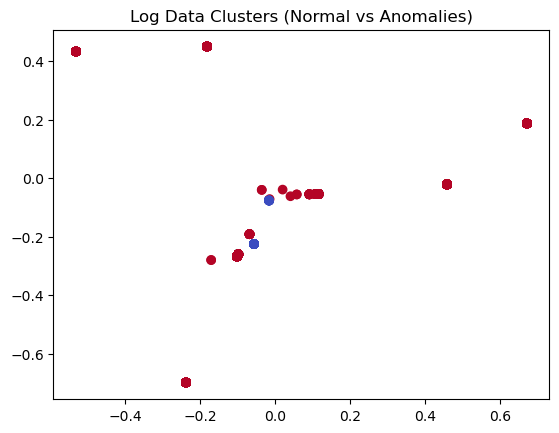

In [8]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X.toarray())
plt.scatter(reduced[:,0], reduced[:,1], c=df['anomaly_score'], cmap='coolwarm')
plt.title("Log Data Clusters (Normal vs Anomalies)")
plt.show()


In [9]:
print(f"Total logs analyzed: {len(df)}")
print(f"Anomalous logs detected: {sum(df['anomaly_score']==-1)}")

Total logs analyzed: 2000
Anomalous logs detected: 100


In [10]:
print("Percentage of anomalies:", round(sum(df['anomaly_score']==-1)/len(df)*100, 2), "%")

Percentage of anomalies: 5.0 %


In [11]:
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from collections import Counter
import os
import seaborn as sns

In [12]:
use_sentence_transformers = True
try:
    from sentence_transformers import SentenceTransformer
except Exception:
    use_sentence_transformers = False
    from transformers import BertTokenizer, BertModel
    import torch

sns.set(style="whitegrid")

c:\Users\shriy\anaconda3\envs\shriya\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [13]:
logfile = "HDFS_2k.log"  
if not os.path.exists(logfile):
    raise FileNotFoundError(f"{logfile} not found in working directory. Upload your log file or change 'logfile' variable.")

df = pd.read_csv(logfile, header=None, names=['raw_log'])
df = df.reset_index(drop=True)
print(f"Loaded {len(df)} log lines.")

Loaded 2000 log lines.


In [14]:
def clean_log(text):
    if pd.isna(text):
        return ""
    text = str(text)
    # Remove timestamps/IPs/numbers but keep words
    text = re.sub(r'\d+\.\d+\.\d+\.\d+', ' ', text)  # remove IPs
    text = re.sub(r'\d+', ' ', text)                 # remove standalone numbers
    text = re.sub(r'[^a-zA-Z ]', ' ', text)          # remove special chars
    text = re.sub(r'\s+', ' ', text)                 # normalize spaces
    return text.lower().strip()

df['clean_log'] = df['raw_log'].apply(clean_log)

In [15]:
if 'timestamp' not in df.columns:
    df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')

C:\Users\shriy\AppData\Local\Temp\ipykernel_14180\2997983649.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')


In [16]:
tfidf_max_features = 5000
vectorizer = TfidfVectorizer(max_features=tfidf_max_features, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['clean_log'].astype(str))
print("TF-IDF features shape:", X_tfidf.shape)


TF-IDF features shape: (2000, 50)


In [17]:
iso_tfidf = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
tfidf_labels = iso_tfidf.fit_predict(X_tfidf.toarray())  # -1 anomaly, 1 normal
df['iso_tfidf_label'] = tfidf_labels
print("TF-IDF IsolationForest complete. Anomalies:", sum(tfidf_labels == -1))


TF-IDF IsolationForest complete. Anomalies: 89


In [18]:
anomalous_text = " ".join(df.loc[df['iso_tfidf_label']==-1, 'clean_log'].astype(str).tolist())
top_terms = Counter(anomalous_text.split()).most_common(20)
print("\nTop terms in TF-IDF-detected anomalous logs (word:count):")
for w,c in top_terms[:15]:
    print(f"{w}: {c}")


Top terms in TF-IDF-detected anomalous logs (word:count):
dfs: 104
blk: 104
info: 89
block: 69
fsnamesystem: 54
namesystem: 54
allocateblock: 54
user: 54
root: 54
temporary: 54
task: 54
part: 54
randtxt: 41
m: 41
datablockscanner: 20


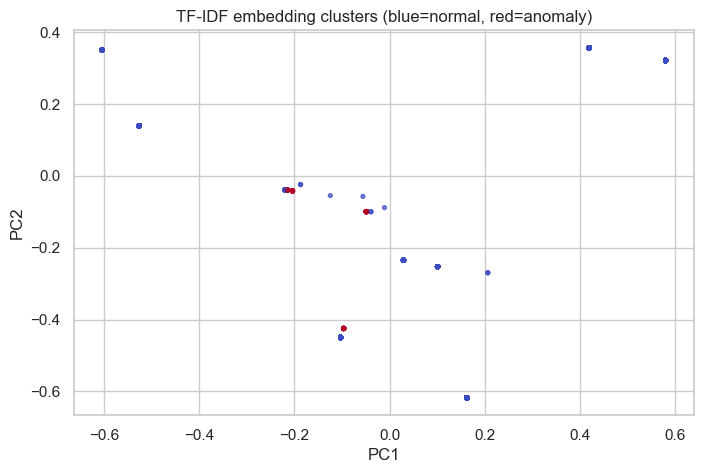

In [19]:
try:
    pca = PCA(n_components=2)
    reduced_tfidf = pca.fit_transform(X_tfidf.toarray())
    plt.figure(figsize=(8,5))
    plt.scatter(reduced_tfidf[:,0], reduced_tfidf[:,1], c=(df['iso_tfidf_label']==-1).astype(int),
                cmap='coolwarm', s=8, alpha=0.7)
    plt.title("TF-IDF embedding clusters (blue=normal, red=anomaly)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()
except MemoryError:
    print("PCA failed due to memory; skip visualization or sample data.")

In [20]:
embed_cap = 2000  # set to None or a large number for full dataset if you have resources
n_rows = len(df) if embed_cap is None else min(embed_cap, len(df))
print(f"\nComputing semantic embeddings for first {n_rows} rows (cap={embed_cap})...")

if use_sentence_transformers:
    s_model_name = 'all-MiniLM-L6-v2'
    s_model = SentenceTransformer(s_model_name)
    embeddings = s_model.encode(df['clean_log'].iloc[:n_rows].tolist(), show_progress_bar=True)
else:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    bert_model.eval()
    embeddings = []
    for txt in df['clean_log'].iloc[:n_rows].tolist():
        inputs = tokenizer.encode_plus(txt, add_special_tokens=True, max_length=32, truncation=True, padding='max_length', return_tensors='pt')
        with torch.no_grad():
            out = bert_model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
        cls = out.last_hidden_state[:,0,:].squeeze().cpu().numpy()
        embeddings.append(cls)
    embeddings = np.vstack(embeddings)

embeddings = np.asarray(embeddings)
print("Embeddings shape:", embeddings.shape)


Computing semantic embeddings for first 2000 rows (cap=2000)...
Embeddings shape: (2000, 768)


In [22]:
iso_emb = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
emb_labels = iso_emb.fit_predict(embeddings)
df_small = df.iloc[:n_rows].copy()
df_small['iso_emb_label'] = emb_labels
print("BERT/semantic IsolationForest complete. Anomalies:", sum(emb_labels == -1))

BERT/semantic IsolationForest complete. Anomalies: 53


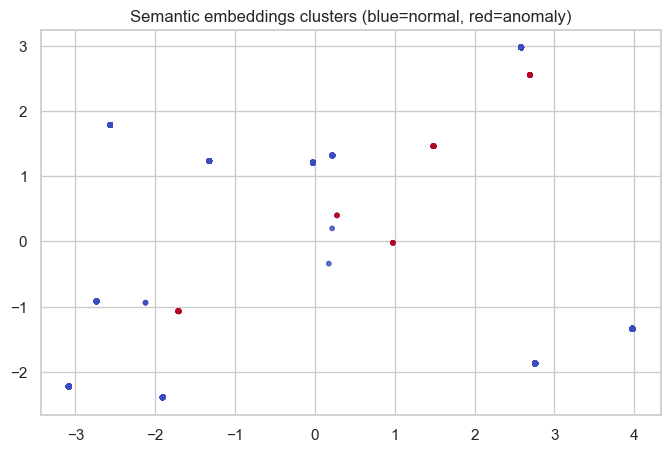

In [23]:
pca2 = PCA(n_components=2)
reduced_emb = pca2.fit_transform(embeddings)
plt.figure(figsize=(8,5))
plt.scatter(reduced_emb[:,0], reduced_emb[:,1], c=(emb_labels==-1).astype(int),
            cmap='coolwarm', s=10, alpha=0.8)
plt.title("Semantic embeddings clusters (blue=normal, red=anomaly)")
plt.show()

In [24]:
print("\nSample anomalous raw log lines (semantic detection):")
display(df_small.loc[df_small['iso_emb_label']==-1, ['timestamp','raw_log']].head(10))


Sample anomalous raw log lines (semantic detection):


,timestamp,raw_log
28,2025-01-02 04:00:00,081109 205931 13 INFO dfs.DataBlockScanner: Ve...
69,2025-01-03 21:00:00,081109 213436 13 INFO dfs.DataBlockScanner: Ve...
120,2025-01-06 00:00:00,081109 234110 26 INFO dfs.FSNamesystem: BLOCK*...
137,2025-01-06 17:00:00,081109 235140 31 INFO dfs.FSNamesystem: BLOCK*...
139,2025-01-06 19:00:00,081109 235311 34 INFO dfs.FSNamesystem: BLOCK*...
150,2025-01-07 06:00:00,081110 000117 33 INFO dfs.FSNamesystem: BLOCK*...
153,2025-01-07 09:00:00,081110 000232 27 INFO dfs.FSNamesystem: BLOCK*...
174,2025-01-08 06:00:00,081110 002253 34 INFO dfs.FSNamesystem: BLOCK*...
175,2025-01-08 07:00:00,081110 002337 13 INFO dfs.DataBlockScanner: Ve...
196,2025-01-09 04:00:00,081110 011237 13 INFO dfs.DataBlockScanner: Ve...


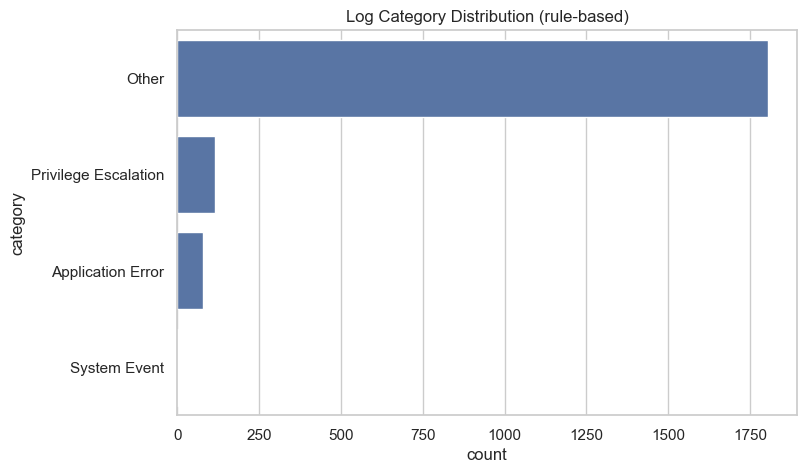

In [25]:
def categorize_log(text):
    t = text.lower()
    if 'fail' in t or 'failed' in t or 'unauth' in t or 'denied' in t:
        return "Authentication Failure"
    if 'unauthor' in t or 'denied' in t or 'access violation' in t:
        return "Access Violation"
    if 'error' in t or 'exception' in t or 'traceback' in t:
        return "Application Error"
    if 'root' in t or 'privilege' in t or 'sudo' in t or 'escalat' in t:
        return "Privilege Escalation"
    if 'malware' in t or 'virus' in t or 'trojan' in t:
        return "Malware Indicator"
    if 'ssh' in t or 'telnet' in t or 'connection' in t:
        return "Network/Connection"
    if 'reboot' in t or 'shutdown' in t or 'start' in t:
        return "System Event"
    return "Other"

df['category'] = df['clean_log'].apply(categorize_log)
plt.figure(figsize=(8,5))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title("Log Category Distribution (rule-based)")
plt.show()

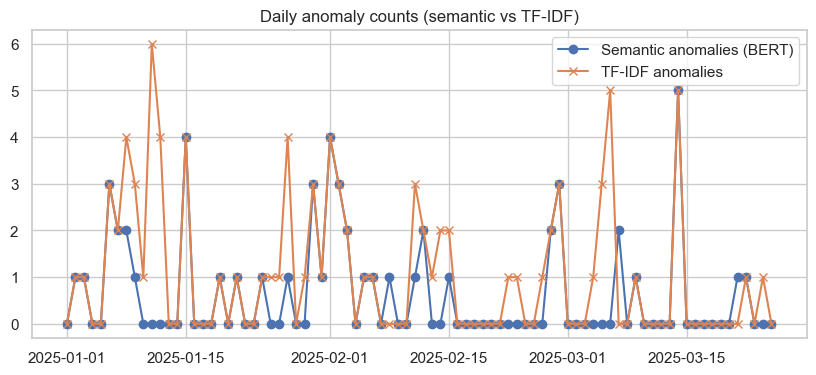

In [26]:
df_small['is_anom'] = (df_small['iso_emb_label'] == -1).astype(int)
df['is_anom_tfidf'] = (df['iso_tfidf_label'] == -1).astype(int)

# aggregated per day/hour
agg_sem = df_small.set_index('timestamp').resample('D')['is_anom'].sum()
agg_tfidf = df.set_index('timestamp').resample('D')['is_anom_tfidf'].sum()

plt.figure(figsize=(10,4))
plt.plot(agg_sem.index, agg_sem.values, label='Semantic anomalies (BERT)', marker='o')
plt.plot(agg_tfidf.index, agg_tfidf.values, label='TF-IDF anomalies', marker='x')
plt.title("Daily anomaly counts (semantic vs TF-IDF)")
plt.legend()
plt.show()

In [27]:
out_fn = "Detected_Anomalies_combined.csv"
# Merge info; prioritize semantic anomalies where available
df_export = df.copy()
df_export['anomaly_semantic'] = 0
df_export.loc[df_export.index[:n_rows], 'anomaly_semantic'] = (df_small['iso_emb_label'].values == -1).astype(int)
df_export['anomaly_tfidf'] = (df_export['iso_tfidf_label'] == -1).astype(int)
df_export['anomaly_any'] = ((df_export['anomaly_semantic']==1) | (df_export['anomaly_tfidf']==1)).astype(int)
df_export[df_export['anomaly_any']==1].to_csv(out_fn, index=False)
print(f"Exported {df_export['anomaly_any'].sum()} anomalous lines to {out_fn}")

Exported 94 anomalous lines to Detected_Anomalies_combined.csv


In [28]:
print("\n===== Summary =====")
print(f"Total logs: {len(df)}")
print(f"TF-IDF anomalies: {int((df['iso_tfidf_label']==-1).sum())} ({round((df['iso_tfidf_label']==-1).sum()/len(df)*100,2)}%)")
print(f"Semantic anomalies (first {n_rows} rows): {int((df_small['iso_emb_label']==-1).sum())} ({round((df_small['iso_emb_label']==-1).sum()/len(df_small)*100,2)}%)")
print(f"Exported combined anomalies to: {out_fn}")
print("=====================\n")


===== Summary =====
Total logs: 2000
TF-IDF anomalies: 89 (4.45%)
Semantic anomalies (first 2000 rows): 53 (2.65%)
Exported combined anomalies to: Detected_Anomalies_combined.csv

